In [1]:
# Import dependancies
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from IPython.display import Image, display

from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import os

In [2]:
# Check CPU or GPU using by tensorflow
cpus = tf.config.list_physical_devices('CPU')
print(cpus)

gpus = tf.config.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Limit driver usage
tf.config.threading.set_intra_op_parallelism_threads(10)
tf.config.threading.set_inter_op_parallelism_threads(10)

if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


In [4]:
# Path of the different folders
train_path = './chest_Xray/train'
test_path = './chest_Xray/test'
val_path = './chest_Xray/val'

# Fixe images size
IMAGE_SIZE = [224, 224]

# List different labels
labels=['NORMAL', 'PNEUMONIA']

In [5]:
# Create CNN model
model = Sequential([
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],1), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],1), activation='relu', padding='same'),
    layers.BatchNormalization(), 
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],1), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],1), activation='relu', padding='same'),
    layers.BatchNormalization(), 
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],1), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=(3,3), strides=1, input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],1), activation='relu', padding='same'),
    layers.BatchNormalization(), 
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=1, input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],1), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=1, input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],1), activation='relu', padding='same'),
    layers.BatchNormalization(), 
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(),
    
    layers.Dense(units=512, activation='relu'),
    layers.Dropout(0.4),
    
    layers.Dense(units=512, activation='relu'),
    layers.Dropout(0.3),
    
    layers.Dense(units=512, activation='relu'),
    layers.Dropout(0.1),
    
    layers.Dense(units=1, activation='sigmoid')
])
# View the structure of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                        

In [6]:
# Creating datas to grayscale
def process_data(data_dir, labels, image_size):
    images = []
    for label in labels:
        dir = os.path.join(data_dir,label)

        class_num = labels.index(label)
        
        # Going through all the images in different folders and resizing them
        for image in os.listdir(dir):
            if image == '.DS_Store':
                continue
            image_read = cv.imread(os.path.join(dir,image),cv.IMREAD_GRAYSCALE)
            image_resized = cv.resize(image_read,(image_size[0],image_size[1]))
            images.append([image_resized,class_num])
    return np.array(images, dtype="object")

In [7]:
train = process_data(train_path, labels, IMAGE_SIZE)
test = process_data(test_path, labels, IMAGE_SIZE)
val = process_data(val_path, labels, IMAGE_SIZE)

print(train.shape)
print(test.shape)
print(val.shape)

(624, 2)


In [8]:
# Print X-Ray PNEUMONIA image
for t in train:
    if labels[t[1]] == labels[1]:
        plt.imshow(t[0], cmap='gray')
        print(labels[t[1]])  
        plt.show()
        break

# Print X-Ray NORMAL image
for t in train:
    if labels[t[1]] == labels[0]:
        plt.imshow(t[0], cmap='gray')
        print(labels[t[1]])  
        plt.show()
        break

"# Print X-Ray PNEUMONIA image\nfor t in train:\n    if labels[t[1]] == labels[1]:\n        plt.imshow(t[0], cmap='gray')\n        print(labels[t[1]])  \n        plt.show()\n        break\n\n# Print X-Ray NORMAL image\nfor t in train:\n    if labels[t[1]] == labels[0]:\n        plt.imshow(t[0], cmap='gray')\n        print(labels[t[1]])  \n        plt.show()\n        break"

In [46]:
def make_gradcam_heatmap(img, img_size, model, last_conv_layer_name, pred_index=None):
    img = img.reshape(-1, img_size[0], img_size[1], 1)
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def superimposed_gradcam(img, img_size, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = img.reshape(img_size[0], img_size[1], 1)
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM
    plt.imshow(superimposed_img)
    plt.show()

NORMAL


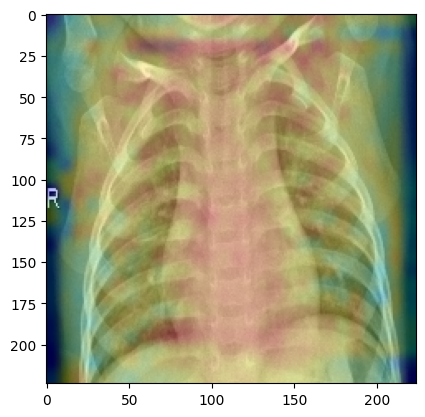

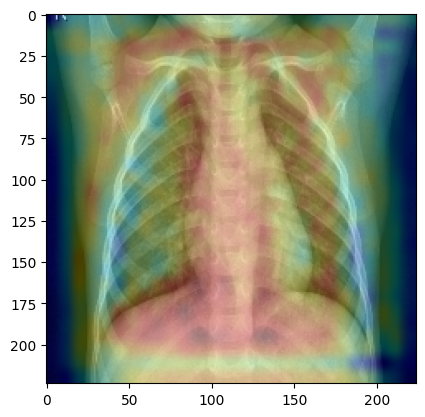

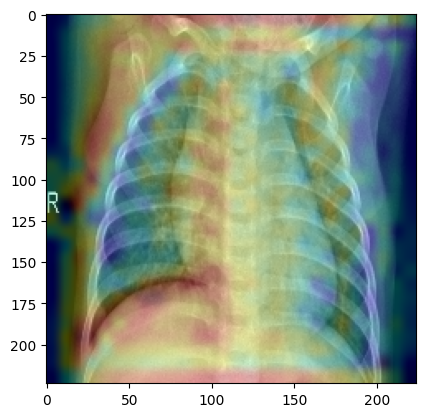

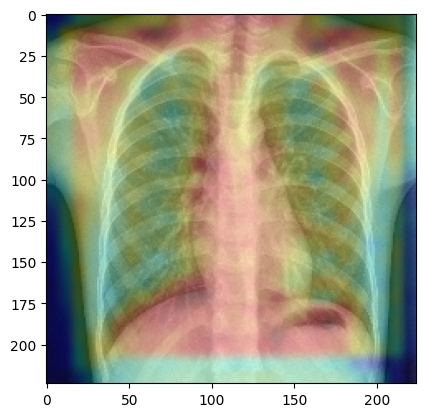

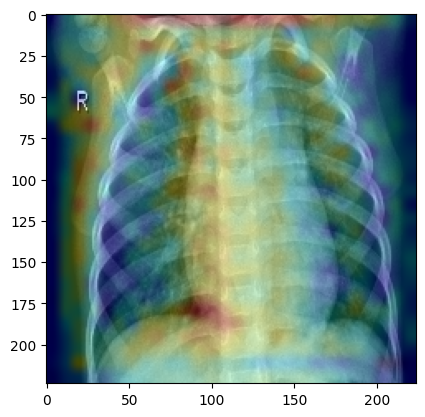

PNEUMONIA


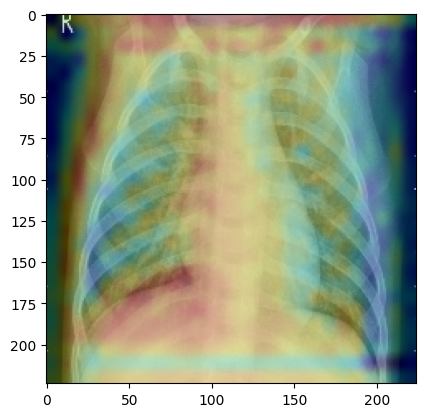

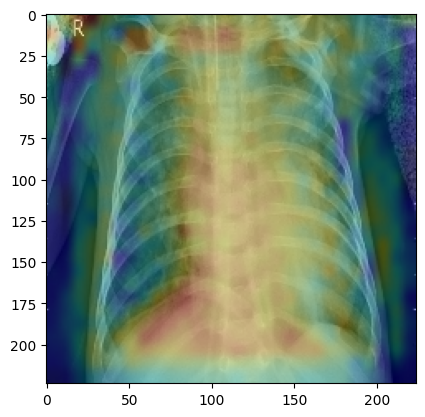

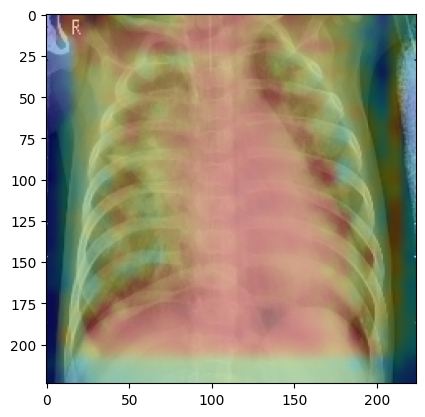

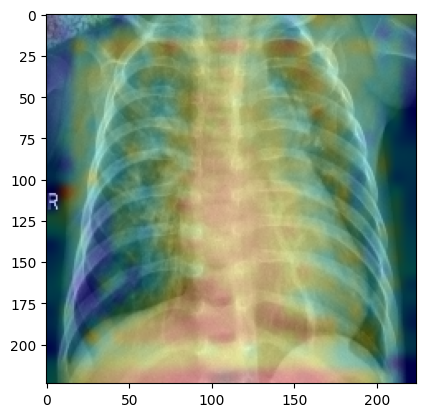

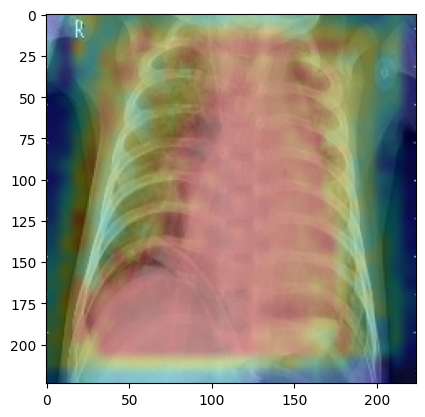

In [49]:
# Show heatmaps on 5 NORMAL and PNEUMONIA images
countNorm, countPneu = 0, 0

for t in test:
    if labels[t[1]] == labels[0] and countNorm < 5:
        if countNorm == 0:
            print(labels[t[1]]) 
        countNorm += 1
        heatmap = make_gradcam_heatmap(t[0], IMAGE_SIZE, model, 'conv2d_7')
        superimposed_gradcam(t[0], IMAGE_SIZE, heatmap)
        
    if labels[t[1]] == labels[1] and countPneu < 5:
        if countPneu == 0:
            print(labels[t[1]]) 
        countPneu += 1
        heatmap = make_gradcam_heatmap(t[0], IMAGE_SIZE, model, 'conv2d_7')
        superimposed_gradcam(t[0], IMAGE_SIZE, heatmap)
    
    if countNorm >= 5 and countPneu >= 5:
        break

In [8]:
X, Y = [], []

for img, label in train:
    X.append(img)
    Y.append(label)

for img, label in val:
    X.append(img)
    Y.append(label)
    
# Reshaping data in order to add channel number (1 = grayscale) and feed it into the Neural Network
X = np.array(X).reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[0], 1)
Y = np.expand_dims(np.array(Y), axis = 1)

# Our validation set only contains 16 images which is way to small.
# Resplit them into a 80% training set and 20% validation set.
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, shuffle = True)

print('Training image shape : ' + str(X_train.shape))
print('Validating image shape : ' + str(X_val.shape))

Training image shape : (4185, 224, 224, 1)
Validating image shape : (1047, 224, 224, 1)


In [9]:
def adjust_contrast(img):
    return tf.image.adjust_contrast(img, 1.4)

In [10]:
BATCH_SIZE = 4

# Generate training dataset
datagen = ImageDataGenerator(
    rescale = 1.,
    preprocessing_function = adjust_contrast,
    rotation_range = 10,
    shear_range = 0.2,
    zoom_range = 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    cval = 0
)

training_set = datagen.flow(X_train, Y_train, batch_size = BATCH_SIZE)
validating_set = datagen.flow(X_val, Y_val, batch_size = BATCH_SIZE)

steps_per_epoch = X_train.shape[0]//BATCH_SIZE
print('Steps per epoch : ' + str(steps_per_epoch))

Steps per epoch : 1046


In [12]:
# Compile model
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001), 
    loss = 'binary_crossentropy', 
    metrics = ['accuracy']
)

In [13]:
# Callback allowing to save the best performing model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '../ZoidbergModel.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True, 
    mode = 'auto'
)

# Train and test the model
hist = model.fit(
    training_set,
    validation_data = validating_set,
    epochs = 15,
    steps_per_epoch = steps_per_epoch,
    callbacks = [checkpoint]
)

Epoch 1/15
1046/1046 [==============================] - ETA: 0s - loss: 0.3681 - accuracy: 0.8374
Epoch 1: val_loss improved from inf to 0.20815, saving model to ZoidbergModel.h5
1046/1046 [==============================] - 44s 39ms/step - loss: 0.3681 - accuracy: 0.8374 - val_loss: 0.2082 - val_accuracy: 0.9150
Epoch 2/15
1046/1046 [==============================] - ETA: 0s - loss: 0.2598 - accuracy: 0.8924
Epoch 2: val_loss did not improve from 0.20815
1046/1046 [==============================] - 40s 38ms/step - loss: 0.2598 - accuracy: 0.8924 - val_loss: 0.2775 - val_accuracy: 0.8959
Epoch 3/15
1046/1046 [==============================] - ETA: 0s - loss: 0.2330 - accuracy: 0.9058
Epoch 3: val_loss improved from 0.20815 to 0.17727, saving model to ZoidbergModel.h5
1046/1046 [==============================] - 41s 39ms/step - loss: 0.2330 - accuracy: 0.9058 - val_loss: 0.1773 - val_accuracy: 0.9341
Epoch 4/15
1046/1046 [==============================] - ETA: 0s - loss: 0.2013 - accurac

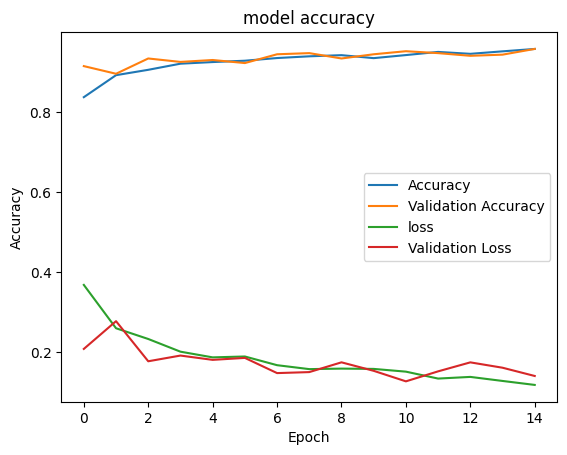

In [14]:
# Show model efficiency
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [15]:
# Get final model to make prediction
final_model = tf.keras.models.load_model('ZoidbergModel.h5')

In [16]:
X_test, Y_test = [], []

for img, label in test:
    X_test.append(img)
    Y_test.append(label)

X_test = np.array(X_test).reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[0], 1)
Y_test = np.expand_dims(np.array(Y_test), axis = 1)

print('Testing image shape : ' + str(X_test.shape))

Testing image shape : (624, 224, 224, 1)


In [17]:
pred = final_model.predict(X_test)
pred_final = np.where(pred > 0.5, 1, 0)

In [29]:
print(classification_report(Y_test, pred_final, target_names=labels))

              precision    recall  f1-score   support

      NORMAL       0.97      0.63      0.76       234
   PNEUMONIA       0.82      0.99      0.89       390

    accuracy                           0.85       624
   macro avg       0.89      0.81      0.83       624
weighted avg       0.87      0.85      0.85       624



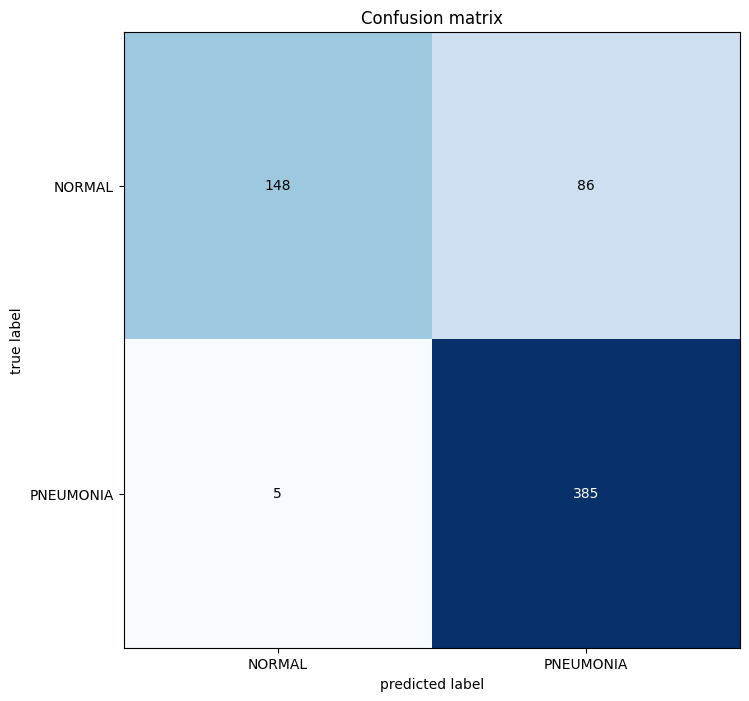

In [18]:
# Get the confusion matrix
CM = confusion_matrix(Y_test, pred_final)

fig, ax = plot_confusion_matrix(conf_mat = CM ,  figsize = (8,8))
plt.title('Confusion matrix')
plt.xticks(range(2), labels, fontsize = 10)
plt.yticks(range(2), labels, fontsize = 10)
plt.show()